In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
%matplotlib inline

import numpy as np
import scipy.stats as sp

import math
from collections import namedtuple
from functools import partial

In [2]:
data = pd.read_csv("prices.txt")

X = np.column_stack((data.values[:,:2].astype(np.float64), np.repeat(1, data.shape[0])))
Y = data.values[:,2].astype(np.float64)

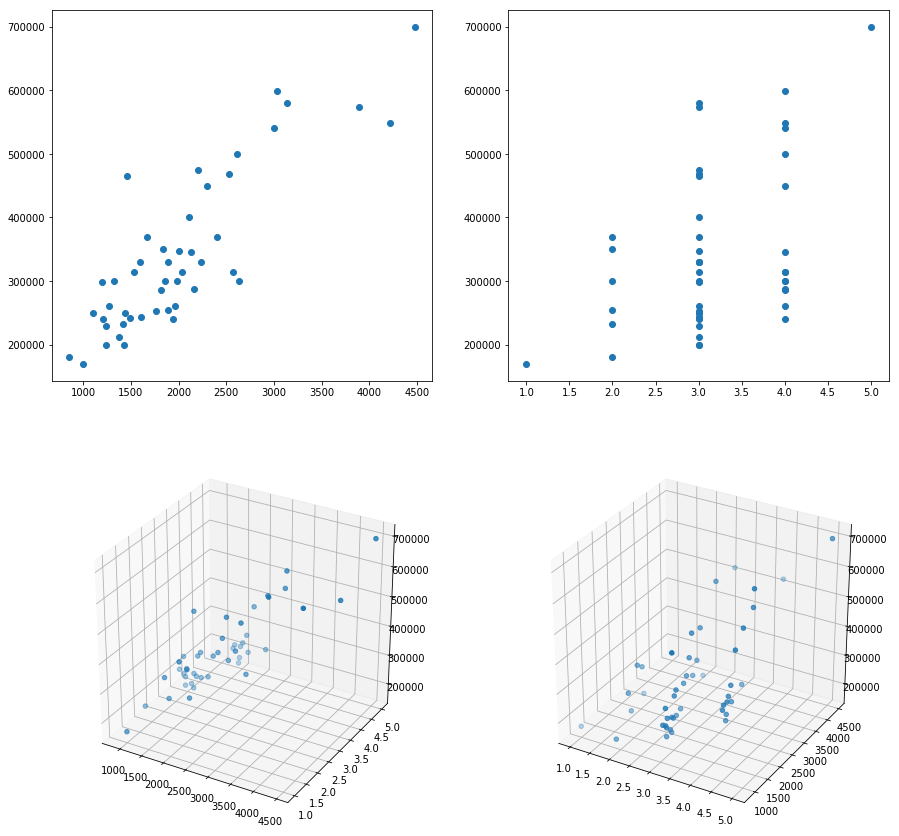

In [3]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221)
ax.scatter(X[:,0], Y)
ax = fig.add_subplot(222)
ax.scatter(X[:,1], Y)
ax = fig.add_subplot(223, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)
ax = fig.add_subplot(224, projection='3d')
ax.scatter(X[:,1], X[:,0], Y)

$$
X = \mathbb{R}^2, Y = \mathbb{R} \\
A=\{g(x, \theta) \mid \theta \in \Theta\} \\
\Theta = \mathbb{R}^3 \\
g(x, \theta) = \theta_0 x_0 + \theta_1 x_1 + \theta_2 \\
Q(\theta, T^l) = \frac{1}{l}\sum_{i=1}^l \left(\theta_0 x_0^i + \theta_1 x_1^i + \theta_2 - y^i\right)^2 \\
\frac{\partial\left(ax+b\right)^2}{\partial x}
= \frac{\partial\left(a^2x^2+2abx+b^2\right)}{\partial x}
= 2a^2x+2ab
= 2a(ax+b)  \\
\begin{align*}
\nabla Q(\theta) &=
\left(
\frac{2}{l}\sum_{i=1}^l x_0^i\left(\theta_0 x_0^i + \theta_1 x_1^i + \theta_2 - y^i\right);
\frac{2}{l}\sum_{i=1}^l x_1^i\left(\theta_0 x_0^i + \theta_1 x_1^i + \theta_2 - y^i\right);
\frac{2}{l}\sum_{i=1}^l \left(\theta_0 x_0^i + \theta_1 x_1^i + \theta_2 - y^i\right)
\right) \\
 &= \frac{2}{l}\left(\theta \cdot X'^\mathrm{T} - y\right) \cdot X',\text{ где } X' = X||1^l
\end{align*}
$$

In [4]:
EPS = 0.0000001
MAX_STEP_N = 50000
ALPHA = 0.0000002

def deviation(X, Y, theta):
    return np.sqrt(1/X.shape[0] * np.sum((theta.dot(X.T)- Y) ** 2))

def loss_gradient(X, Y, theta):
    return 2/X.shape[0] * (theta.dot(X.T) - Y).dot(X)

def gradient_descent(X, Y, theta):
    step_n = 0
    while True:
        new_theta = theta - ALPHA * loss_gradient(X, Y, theta)
#         if (step_n % 2000 == 0):
#             print(new_theta)
        step_n += 1
        if (np.linalg.norm(new_theta - theta) < EPS or step_n >= MAX_STEP_N):
            return new_theta
        theta = new_theta

In [5]:
theta = gradient_descent(X, Y, np.array([100, 10000, 100000], np.float64))

In [6]:
print(theta)

[   108.30687051   9579.7976119   99868.38888283]


In [7]:
deviation(X, Y, theta)

67336.754884317808